# Running Naive Bayes to predict wine ratings

Here, we want to try to predict the rating of the wine using naive bayes. We are using the price, variety, vintage and the fires that happened around the vineyard that the wines came from. By predicting the wine points, growers can decide what variety of grapes to plant in the future, as well as change the prices of exisiting wines to see try to get higher wine entusiast scores. 

In [1]:
import pandas as pd
import numpy as np
import pylab as pl

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels

from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import warnings
%matplotlib inline

In [2]:
# Load the cleaned data into dataframe

""" 
    Information of cleaned dataset:
    
    - Province and Variety of wine is transfomed from a categorical attribute to numerical attribute
    - Vintage of wine is extracted from the title of each wine
    - Rows were removed if there were null values present within each of the three attributes (Province, Variety, Vintage)
    
"""
warnings.simplefilter('ignore')
data = pd.read_csv('../data/final_wine_and_fire_data.csv')
data.dropna(inplace = True)
print(data.shape)
data.head()

(9757, 31)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,...,total_fires_current,sum_fire_size_current,norm_vintage,norm_variety_numerical,norm_price,norm_points,norm_total_fires,norm_sum_fire_size,norm_total_fires_current,norm_sum_fire_size_current
0,0,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,...,202,1756.38,0.009921,0.113960,0.006955,0.070707,0.000000,0.000000,0.450893,0.006877
1,1,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,...,192,639.14,0.009921,0.464387,0.008445,0.070707,0.008929,0.000310,0.428571,0.002502
2,2,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,...,202,1756.38,0.009921,0.626781,0.031793,0.070707,0.000000,0.000000,0.450893,0.006877
3,3,US,"Syrupy and dense, this wine is jammy in plum a...",Estate,86,100.0,California,Napa Valley,Napa,Virginie Boone,...,247,1453.08,0.010913,0.113960,0.047193,0.060606,0.272321,0.005246,0.551339,0.005689
4,4,US,There are intriguing touches to the nose of th...,Golden Horn,86,26.0,California,Santa Ynez Valley,Central Coast,Matt Kettmann,...,109,2711.55,0.011905,0.732194,0.010432,0.060606,0.183036,0.002815,0.243304,0.010616


In [12]:
data.region_2.unique()

array(['Napa', 'Central Coast', 'Sonoma', 'California Other',
       'Sierra Foothills', 'North Coast', 'Napa-Sonoma', 'Central Valley'],
      dtype=object)

In [13]:
# Helper function to count the number of samples in each cluster

def label_count(labels):

	lab_count = dict()

	for x in labels:
		if x in lab_count:
			lab_count[x] += 1
		else:
			lab_count[x] = 1

	print(lab_count)

	return

In [14]:
label_count(data['region_2'])

# napa = sac delta
# sonoma = sac delta
# 

{'Napa': 1605, 'Central Coast': 3711, 'Sonoma': 3032, 'California Other': 489, 'Sierra Foothills': 401, 'North Coast': 138, 'Napa-Sonoma': 333, 'Central Valley': 48}


In [3]:
#from  https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#used to plot the confusion matrix nicely

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax


In [4]:
def model_stats(y_true, y_pred):
    try:
        plot_confusion_matrix(y_true, y_pred, unique_labels(y_true))
    except:
        conf_mat = confusion_matrix(y_true, y_pred)
        print('confusion matrix')
        print(conf_mat)
    
    stats = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
    print('\nprecision')
    print(stats[0])
    print('recall')
    print(stats[1])
    print('f1 score')
    print(stats[2])
    print('\n')

Here we run gaussian naive bayes on our data. Gaussian naive bayes assumes that the likelyhood of the features have a gaussian distribution. We can see that trying to run naive bayes to predict the raw point value has a very low accuracy because there are too many classes to predict on since the price ranges from 80-100. The best accuracy from predicting on points is only 16%, and from the confusion matrix we can see that the algorithm just predicts the same score for all test samples. 

In [5]:
x = data.loc[:, ['norm_vintage', 'norm_price', 'norm_variety_numerical']]
y = data.loc[:, 'points']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)
model_stats(y_test, predict)

print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y ,cv = 5))

confusion matrix
[[  0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0
    0]
 [  0   0   1   0   0   0   0   0   3   0   2   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   1  10   0   5   0   0   1   0   0   0   0
    0]
 [  0   0   1   0   0   0   0   2  21   0   5   1   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   6  36   0  10   0   2   2   0   0   0   0
    0]
 [  0   0   1   0   0   0   0   7  68   0  29   1   5   3   0   0   0   0
    0]
 [  0   0   5   0   0   0   0  12  85   0  22   3   3   2   0   0   0   0
    0]
 [  0   0   1   0   0   0   0   5 136   0  67   3   6   8   0   0   0   0
    0]
 [  0   0   6   0   0   0   0   8  86   0  34   1   4   6   0   0   0   0
    0]
 [  0   0   1   0   0   0   0   5 181   0 111  14   7  21   0   0   0   0
    0]
 [  0   0   2   0   0   0   0   4 120   0 102   9  14  21   0   0   0   0
    0]
 [  0   0  

In [6]:
x = data.loc[:, ['norm_total_fires', 'norm_sum_fire_size']]
y = data.loc[:, 'points']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)

model_stats(y_test, predict)
print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y , cv = 5))

confusion matrix
[[  0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   1   0   0   0   0   0   1   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0   6   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   1   0   0   0   0  12   2   0   0   0   0   0   0
    2]
 [  0   1   0   0   0   0   0   0   0   0  25   2   0   0   0   0   0   0
    2]
 [  0   1   0   0   0   2   0   0   0   0  38   3   0   2   0   0   0   0
   10]
 [  0   0   0   0   0   3   0   0   0   0  98   2   0   2   0   0   0   0
    9]
 [  0   0   0   0   0   4   0   0   1   0 106   7   0   2   0   0   0   0
   12]
 [  0   2   0   0   0   2   0   0   0   0 190   4   0   5   0   0   0   0
   23]
 [  0   0   0   0   0   0   0   0   0   0 127   1   0   6   0   0   0   0
   11]
 [  0   1   0   0   0   2   0   0   4   0 263   5   0   7   0   0   0   0
   58]
 [  0   0   0   0   0   7   0   0   1   0 215   1   0   9   0   0   0   0
   39]
 [  0   0  

In [7]:
x = data.loc[:, 'points']
x = np.array(x, dtype=pd.Series)
x = x.reshape(-1, 1)
y = data.loc[:, 'points']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.33, random_state=0)

n_bayes = MultinomialNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)
model_stats(y_test, predict)

print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y ,cv = 5))

confusion matrix
[[  0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0  10   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0  26   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0  44   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0  89   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 200   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 236   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 386   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 223   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 554   0   0   0   0   0   0   0
    0]
 [  0   0   0   0   0   0   0   0   0   0 445   0   0   0   0   0   0   0
    0]
 [  0   0  

To try to improve our accuracy, we binned the points into 3 groups, good, medium and mediocre wines. After running naive bayes on the binned data, we can see that the accuracy increases to ~40%. From the confusion matrices, we can see that the algorithm seems to ignore one of the bins when predicting, which could be due to the fact that our data is not very correlated. 

In [8]:
points = data.loc[:,'points']
points = np.array(points, dtype=pd.Series)
points = points.reshape(-1, 1)
cluster = KMeans(n_clusters = 3, random_state = 0).fit(points)
point_bins = cluster.labels_

data['point_bin'] = point_bins

Confusion matrix, without normalization
[[398 172  41]
 [155 329 100]
 [313 373  71]]


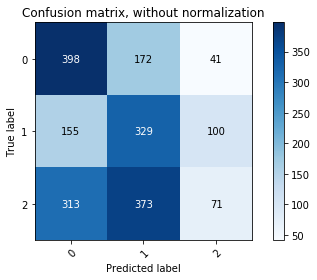


precision
0.38635493329876924
recall
0.4088114754098361
f1 score
0.3605432143414068


5 fold cross validation accuracies
[0.41137295 0.4272541  0.40829918 0.41209636 0.41230769]


In [9]:
x = data.loc[:, ['norm_price', 'norm_total_fires', 'norm_sum_fire_size']]
y = data.loc[:, 'point_bin']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)

model_stats(y_test, predict)
print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y , cv = 5))

Confusion matrix, without normalization
[[307 290  14]
 [ 86 486  12]
 [200 543  14]]


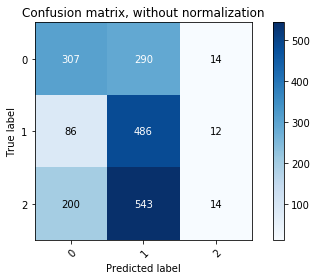


precision
0.40801737513232206
recall
0.413422131147541
f1 score
0.32606329432398085


5 fold cross validation accuracies
[0.42520492 0.43852459 0.40932377 0.42029728 0.40615385]


In [10]:
x = data.loc[:, ['norm_price', 'norm_total_fires_current', 'norm_sum_fire_size_current']]
y = data.loc[:, 'point_bin']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)

model_stats(y_test, predict)
print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y , cv = 5))

Confusion matrix, without normalization
[[448 133  30]
 [257 271  56]
 [432 280  45]]


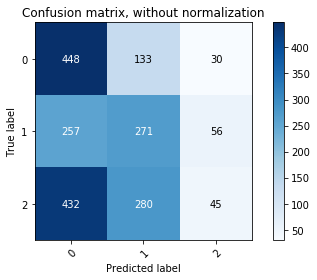


precision
0.37508407133067906
recall
0.39139344262295084
f1 score
0.3276335371800478


5 fold cross validation accuracies
[0.39139344 0.40778689 0.40778689 0.4249103  0.42615385]


In [11]:
x = data.loc[:, ['norm_price', 'lat', 'lon']]
y = data.loc[:, 'point_bin']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=0)

n_bayes = GaussianNB()
n_bayes.fit(x_train,y_train)

predict = n_bayes.predict(x_test)

model_stats(y_test, predict)
print('5 fold cross validation accuracies')
print(cross_val_score(n_bayes, x ,y , cv = 5))